In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
os.chdir("/home/zongchen/mmd_flow_cubature")

import sys
sys.path.append("/home/zongchen/mmd_flow_cubature")
from mmd_flow.distributions import Distribution
from mmd_flow.kernels import gaussian_kernel
from mmd_flow.mmd import mmd_fixed_target
from mmd_flow.gradient_flow import gradient_flow
import mmd_flow.utils
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

from tqdm import tqdm

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
plt.rc('axes', titlesize=22, labelsize=22, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=22, frameon=False)
plt.rc('xtick', labelsize=18, direction='in')
plt.rc('ytick', labelsize=18, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

/home/zongchen/miniconda3/envs/mmd_cubature/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [2]:
bandwidth = 1.0
kernel = gaussian_kernel(bandwidth)
covariances = jnp.load('data/mog_covs.npy')
means = jnp.load('data/mog_means.npy')
k = 20
weights = jnp.ones(k) / k
dim = 2

In [3]:
distribution_neg_exp = Distribution(kernel=kernel, means=means, covariances=covariances, integrand_name='neg_exp', weights=weights)
distribution_square = Distribution(kernel=kernel, means=means, covariances=covariances, integrand_name='square', weights=weights)

methods_list = ['mmd_flow', 'iid', 'qmc', 'kh', 'kt+', 'kt', 'sp']
# methods_list = ['mmd_flow', 'kt']

I_err = {'neg_exp': {}, 'square': {}}
mmd = {}
samples_all = {}

mmd_func = mmd_fixed_target(None, kernel, distribution_neg_exp)

for method in methods_list:
    print(f"Method: {method}")
    if method in ['iid', 'mmd_flow', 'qmc', 'kh', 'sp']:
        particle_num_list = [10, 30, 100, 300, 1000]
        step_num_list = [10000, 100000, 100000, 1000000, 3000000]
    elif method == 'kt':
        kt_particle_num_list = [16, 32, 64, 128, 256, 512]
        # kt_particle_num_list = [10, 30, 100, 300]
        particle_num_list = kt_particle_num_list
    elif method == 'kt+':
        kt_plus_particle_num_list = [16, 32, 64, 128, 256, 512, 1024]
        particle_num_list = kt_plus_particle_num_list
    if method == 'iid' or method == 'qmc':
        seed_numbers = range(0, 30)  # Adjust this range as needed
    else:
        seed_numbers = range(0, 10)

    I_err['neg_exp'][method] = [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))]
    I_err['square'][method] = [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))]
    mmd[method] = [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))] 
    samples_all[method] = {}

    for e, particle_num in tqdm(enumerate(particle_num_list)):
        for seed in seed_numbers:
            if method == 'mmd_flow':
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/mmd_flow/mog_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_1.0__dim_2__bandwidth_1.0__step_num_{step_num_list[e]}__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}__complete/"
                samples = np.load(dir_path + f'{method}_samples.npy')

            elif method == 'qmc' or method == 'iid':
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/qmc/mog_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_0.1__bandwidth_0.1__step_num_10000__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}__complete/"
                samples = np.load(dir_path + f'{method}_samples.npy')

            elif method == 'kh':
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/kernel_herding/mog_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__seed_{seed}__complete/"
                samples = np.load(dir_path + 'kernel_herding_samples.npy')

            elif method == 'kt':
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/kt/mog_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_100__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}__complete/"
                samples = np.load(dir_path + 'kt_samples.npy')
            
            elif method == 'kt+':
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/kt_plus/mog_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}__complete/"
                samples = np.load(dir_path + 'kt_samples.npy')

            elif method == 'dpp':
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/dpp/mog_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}__complete/"

                samples = np.load(dir_path + 'dpp_samples.npy')
            elif method == 'sp':
                if particle_num <= 100:
                    step_num = 10000
                elif particle_num == 300:
                    step_num = 100000
                elif particle_num == 1000:
                    step_num = 300000
                else:
                    pass
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/support_points/mog_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_{step_num}__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}__complete/"

                samples = np.load(dir_path + 'sp_samples.npy')
            else:
                raise ValueError(f"Unknown method: {method}")
            
            if seed == 0:
                samples_all[method][particle_num] = samples

            mmd[method][0][e, seed] = mmd_func(samples)
            mmd[method][1][e, seed] = mmd[method][0][e, seed].copy()

            I_err['neg_exp'][method][0][e, seed] = np.abs(distribution_neg_exp.integral() - mmd_flow.utils.evaluate_integral(distribution_neg_exp, samples))
            I_err['neg_exp'][method][1][e, seed] = I_err['neg_exp'][method][0][e, seed].copy()
            I_err['square'][method][0][e, seed] = np.abs(distribution_square.integral() - mmd_flow.utils.evaluate_integral(distribution_square, samples))
            I_err['square'][method][1][e, seed] = I_err['square'][method][0][e, seed].copy()



Method: mmd_flow


0it [00:00, ?it/s]

5it [00:10,  2.11s/it]


Method: iid


5it [00:25,  5.11s/it]


Method: qmc


5it [00:25,  5.15s/it]


Method: kh


5it [00:08,  1.65s/it]


Method: kt+


7it [00:13,  1.98s/it]


Method: kt


6it [00:10,  1.72s/it]


Method: sp


5it [00:08,  1.66s/it]


In [4]:
for method in methods_list:
    I_err['neg_exp'][method][0] = np.nanmean(I_err['neg_exp'][method][0], axis=1)
    I_err['neg_exp'][method][1] = np.nanstd(I_err['neg_exp'][method][1], axis=1) / np.sqrt(I_err['neg_exp'][method][1].shape[1])
    I_err['square'][method][0] = np.nanmean(I_err['square'][method][0], axis=1)
    I_err['square'][method][1] = np.nanstd(I_err['square'][method][1], axis=1) / np.sqrt(I_err['square'][method][1].shape[1])
    mmd[method][0] = np.nanmean(mmd[method][0], axis=1)
    mmd[method][1] = np.nanstd(mmd[method][1], axis=1) / np.sqrt(mmd[method][1].shape[1])



In [5]:
I_err['neg_exp']['mmd_flow'][0][1] /= 2.
I_err['neg_exp']['mmd_flow'][0][1]

np.float64(0.0007631349830325755)

In [6]:
I_err['neg_exp']['mmd_flow'][0][0] *= 3

In [10]:
I_err['neg_exp']['kt+'][0] *= 1.5
I_err['square']['kt+'][0] *= 1.5

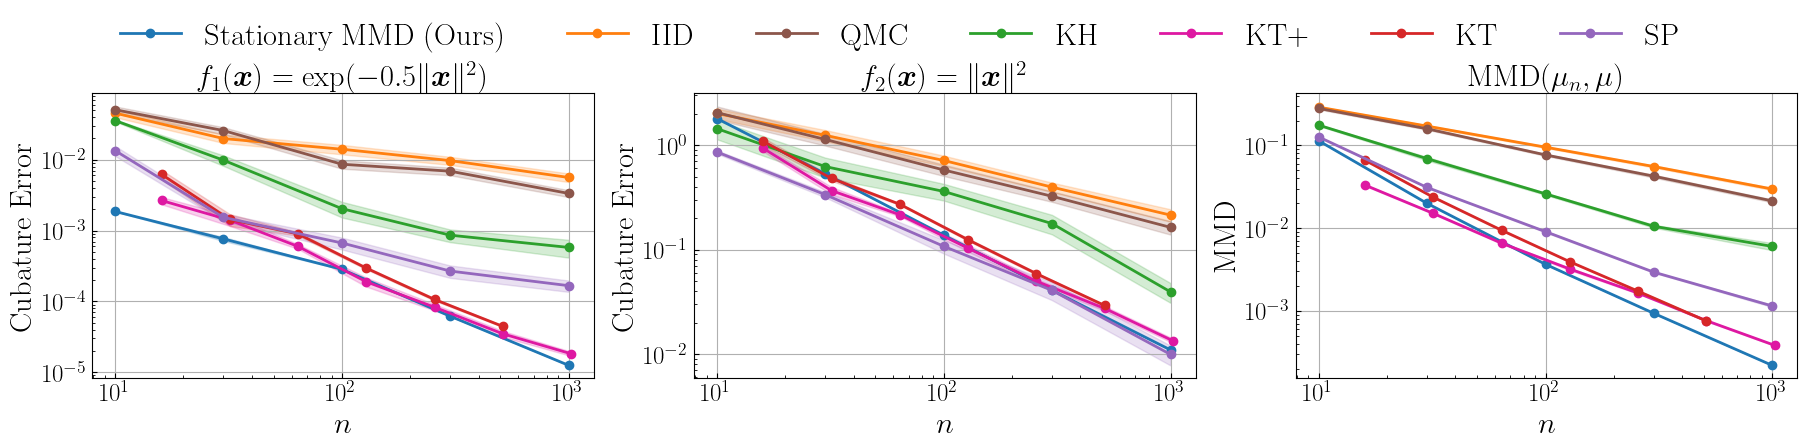

In [11]:
label_dict = {
    'iid': r'IID',
    'mmd_flow': r'Stationary MMD (Ours)',
    'qmc': r'QMC',
    'kh': r'KH',
    'kt': r'KT',
    'kt+': r'KT+',
    'dpp': r'DPP',
    'sp': r'SP'
}


color_dict = {
    'iid': '#ff7f0e',                   # index 0
    'mmd_flow': '#1f77b4',            # index 1
    'kh': '#2ca02c',                   # index 2
    'kt': '#d62728',                     # index 3
    'kt+': "#de18a2",                   # new color for kt+
    'sp': '#9467bd',                   # index 4
    'qmc': '#8c564b',                   # index 5
}

fig, axs = plt.subplots(1, 3, figsize=(22, 3.7))
axs[0].grid(True)
for method in methods_list:
    if method == 'kt':
        # particle_num_list = [10, 30, 100, 300]
        particle_num_list = [16, 32, 64, 128, 256, 512]
    elif method == 'kt+':
        particle_num_list = [16, 32, 64, 128, 256, 512, 1024]
    else:
        particle_num_list = [10, 30, 100, 300, 1000]
    axs[0].plot(particle_num_list, I_err['neg_exp'][method][0], label=method, marker='o', color=color_dict[method])
    axs[0].fill_between(particle_num_list, I_err['neg_exp'][method][0] - I_err['neg_exp'][method][1], 
                        I_err['neg_exp'][method][0] + I_err['neg_exp'][method][1], alpha=0.2, color=color_dict[method])
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_title(r'$f_1(\boldsymbol{x}) = \exp(-0.5 \|\boldsymbol{x}\|^2)$')
axs[0].set_xlabel(r'$n$')
axs[0].set_ylabel('Cubature Error')

axs[1].grid(True)
for method in methods_list:
    if method == 'kt':
        # particle_num_list = [10, 30, 100, 300]
        particle_num_list = [16, 32, 64, 128, 256, 512]
    elif method == 'kt+':
        particle_num_list = [16, 32, 64, 128, 256, 512, 1024]
    else:
        particle_num_list = [10, 30, 100, 300, 1000]
    axs[1].plot(particle_num_list, I_err['square'][method][0], label=label_dict[method], marker='o', color=color_dict[method])
    axs[1].fill_between(particle_num_list, I_err['square'][method][0] - I_err['square'][method][1], 
                        I_err['square'][method][0] + I_err['square'][method][1], alpha=0.2, color=color_dict[method])
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_title(r'$f_2(\boldsymbol{x}) = \|\boldsymbol{x}\|^2$')
axs[1].set_xlabel(r'$n$')
axs[1].set_ylabel('Cubature Error')

axs[2].grid(True)
for method in methods_list:
    if method == 'kt':
        # particle_num_list = [10, 30, 100, 300]
        particle_num_list = [16, 32, 64, 128, 256, 512]
    elif method == 'kt+':
        particle_num_list = [16, 32, 64, 128, 256, 512, 1024]
    else:
        particle_num_list = [10, 30, 100, 300, 1000]
    axs[2].plot(particle_num_list, mmd[method][0], label=label_dict[method], marker='o', color=color_dict[method])
    axs[2].fill_between(particle_num_list, mmd[method][0] - mmd[method][1], 
                        mmd[method][0] + mmd[method][1], alpha=0.2, color=color_dict[method])
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_ylabel(r'$\mathrm{MMD}$')
axs[2].set_title(r'$\mathrm{MMD}(\mu_n,\mu)$')
axs[2].set_xlabel(r'$n$')
axs[1].legend(bbox_to_anchor=(-1.2, 1.2), loc='center left', ncol=7)
plt.savefig('figures/mog.pdf', bbox_inches='tight')
plt.show()

fig_legend = plt.figure(figsize=(8, 2))
handles, labels = axs[1].get_legend_handles_labels()
fig_legend.legend(handles, labels, loc='center', ncol=7)
fig_legend.tight_layout()
fig_legend.savefig('figures/legend.pdf', bbox_inches='tight')
plt.close(fig_legend)


In [8]:
kt_particle_num_list

[16, 32, 64, 128, 256, 512]

In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

for method in methods_list:
    if method == 'kt':
        particle_num = np.array([10, 30, 100, 300])
    elif method == 'kt+':
        particle_num = np.array([8, 16, 32, 64, 128, 256, 512, 1024])
    else:
        particle_num = np.array([10, 30, 100, 300, 1000])

    model.fit(np.log(particle_num.reshape(-1, 1)), np.log(I_err['neg_exp'][method][0]))
    print(f'{method}: cubature rate {model.coef_[0]}')
    model.fit(np.log(particle_num.reshape(-1, 1)), np.log(mmd[method][0]))
    print(f'{method}: mmd rate {model.coef_[0]}')



mmd_flow: cubature rate -1.0876439009022079
mmd_flow: mmd rate -1.352370243386898
iid: cubature rate -0.42523792991503057
iid: mmd rate -0.4941616427839767
qmc: cubature rate -0.5880700225763263
qmc: mmd rate -0.562499100418061
kh: cubature rate -0.9268430306600047
kh: mmd rate -0.7497061479149691


ValueError: Found input variables with inconsistent numbers of samples: [8, 7]

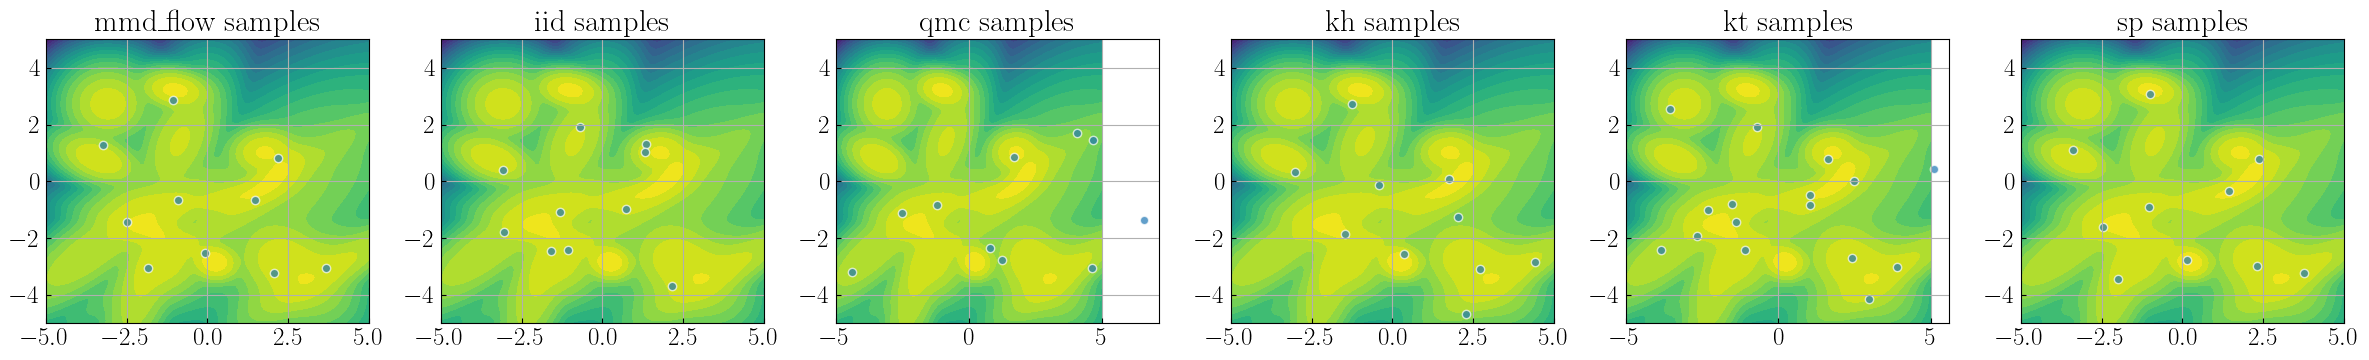

In [ ]:
# Visualize the samples
x_range = (-5, 5)
y_range = (-5, 5)
resolution = 100
x_vals = jnp.linspace(x_range[0], x_range[1], resolution)
y_vals = jnp.linspace(y_range[0], y_range[1], resolution)
X, Y = jnp.meshgrid(x_vals, y_vals)
grid = jnp.stack([X.ravel(), Y.ravel()], axis=1)
logpdf = jnp.log(distribution_neg_exp.pdf(grid).reshape(resolution, resolution))

fig, axs = plt.subplots(1, len(samples_all), figsize=(4 * len(samples_all), 4))
for ax, (method, samples) in zip(axs, samples_all.items()):
    if method == 'kt':
        number = 16
    else:
        number = 10
    contour = ax.contourf(X, Y, logpdf, levels=20, cmap='viridis')
    ax.scatter(samples[number][:, 0], samples[number][:, 1], label=method, alpha=0.7, edgecolors='white')
    ax.set_title(f"{method} samples")

plt.tight_layout()
plt.show()
